In [1]:
import os
import pandas as pd
import numpy as np
import h3
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial import distance
import os
from shapely.geometry import Polygon
import sys
sys.path.append("../")
from utils.cluster import ClusterAttr
import geopandas as gpd
"""This time only looks at within city data."""
plt.rcParams["figure.figsize"] = [3, 4]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
# load tsne data
# ROOTFOLDER = "D:/Dropbox (Personal)/Personal Work/_Projects2023/01_city-never-was"
ROOTFOLDER = "/Users/yuan/Dropbox (Personal)/Personal Work/_Projects2023/01_city-never-was"
DATA_FOLDER = f"{ROOTFOLDER}/_data/_curated/c_seg_hex"
DATA_EXPORT = f"{ROOTFOLDER}/_data/_curated/c_hex_cluster"
SEG_FOLDER = f"{ROOTFOLDER}/_data/_curated/c_analysis"
if not os.path.exists(DATA_EXPORT):
    os.makedirs(DATA_EXPORT)
BOUND_FOLDER = f"{ROOTFOLDER}/_data/_raw/r_boundary_osm"

# GRAPHIC_PATH = "/group/geog_pyloo/08_GSV/_graphic/cluster/allcities"
GRAPHIC_PATH = f"{ROOTFOLDER}/_graphic/cluster_figure"
if not os.path.exists(GRAPHIC_PATH):
    os.makedirs(GRAPHIC_PATH)
res = 9
N_CAT = 27
# PREFIXFULL = "_built_environment"
PREFIXFULL = ""

FILENAME_WITHIN = "c_seg_cat={N_CAT}_res={res}_withincity{prefixfull}_tsne.parquet"
FILENAME_ORI_WITHIN = "c_seg_cat={N_CAT}_res={res}_withincity.parquet"


In [3]:
variables_sel_top1_order = ClusterAttr.variables_sel_top1_order
variables_sel_top1_order_r = ClusterAttr.variables_sel_top1_order_r
variables_sel_top1_order_all = ClusterAttr.variables_sel_top1_order_all
variables_sel_top1_order_all_r = ClusterAttr.variables_sel_top1_order_all_r
len(variables_sel_top1_order)
variables_sel_order = ClusterAttr.variables_sel_order
# variables_sel_order

# 1. Select the Hexagons within city

In [6]:
def plot_wss_kmean(data, N, comment):
    """Try Kmean instead"""
    
    wss = []
    distorsions = []
    silhouette = []
    
    for i in range(2,N):
        print("cluster: ", i)
        # fcm_vol = FCM(n_clusters=i, random_state=0)
        km = KMeans(n_clusters=i, random_state=0)
        km.fit(data)
        wss.append(km.inertia_)
        distorsions.append(sum(np.min(distance.cdist(data,
        km.cluster_centers_, 'euclidean'),axis=1)) /
        data.shape[0])
        # silhouette.append(silhouette_score(data, km.labels_))
        
        
    sns.set(style="whitegrid")
    sns.set_context("paper", rc={"font.size":10,"axes.titlesize":12,"axes.labelsize":12})

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    ax1, ax2 = axes
    ax1.plot(range(2,N), wss, 'bx-', color='black')
    # make sure the x-axis is in integers
    ax1.set_xticks(np.arange(2, N, step=1))
    ax1.set_xlabel('Number of clusters $K$')
    ax1.set_ylabel('Inertia')
    ax1.set_title('The Elbow Method showing the optimal $K$')
    
    ax2.plot(range(2,N), distorsions, 'bx-', color='black')
    # make sure the x-axis is in integers
    ax2.set_xticks(np.arange(2, N, step=1))
    ax2.set_xlabel('Number of clusters $K$')
    ax2.set_ylabel('Distorsion')
    ax2.set_title('The Elbow Method showing the optimal $K$')
    
    # ax3.plot(range(2,N), silhouette, 'bx-', color='black')
    # # make sure the x-axis is in integers
    # ax3.set_xticks(np.arange(2, N, step=1))
    # ax3.set_xlabel('Number of clusters $K$')
    # ax3.set_ylabel('Silhouette Score')
    # ax3.set_title('The Silhouette Method showing the optimal $K$')
    fig.savefig(os.path.join(GRAPHIC_PATH,f"elbow_silhouette_volume_{N}_{comment}.png"), dpi=200, bbox_inches = 'tight')
    plt.show()
    
    return wss, distorsions



def cell_to_shapely(cell):
    coords = h3.h3_to_geo_boundary(cell)
    flipped = tuple(coord[::-1] for coord in coords)
    return Polygon(flipped)

def get_data_within_bound(df):
    df_within = []
    fullcity = df["city_lower"].unique().tolist()
    for cityabbr in tqdm(fullcity):
        if "," in cityabbr:
            city_short = cityabbr.split(",")[0]
        else:
            city_short = cityabbr
        bound = gpd.read_file(os.path.join(BOUND_FOLDER, f"{city_short}.geojson"))
        sample = df[df["city_lower"]==cityabbr].reset_index(drop = True)
        h3_geoms = sample['hex_id'].apply(lambda x: cell_to_shapely(x))
        df_sel_gdf = gpd.GeoDataFrame(sample[['city_lower', 'hex_id', 'img_count', 'res', 'tsne_1', 'tsne_2']], geometry = h3_geoms)
        df_sel_gdf.crs = "EPSG:4326"
        df_sel_gdf_within = gpd.sjoin(df_sel_gdf, bound[['geometry']])
        df_sel_gdf_within['city_lower'] = cityabbr
        df_within.append(df_sel_gdf_within.drop(['index_right','geometry'], axis=1))
    df_within = pd.concat(df_within).reset_index(drop = True)
    df_within.to_parquet(os.path.join(DATA_FOLDER, FILENAME_WITHIN.format(res = res)))
    print("Done saving within city data")
    return df_within

In [7]:
# load hexagon within city boundary # RUN ONCE
# df_within = get_data_within_bound(df)
# df_ori_within = df_ori.merge(df_within[['city_lower', 'hex_id']], on = ['hex_id', 'city_lower'], how = 'inner')
# df_ori_within.to_parquet(os.path.join(DATA_FOLDER, FILENAME_ORI_WITHIN.format(res = res)), index = False)

# 2. Recalculate the TSNE embedding 
c2_generate_tnse.py (in ai-research server)

# 2. Cluster from here

In [23]:
def generate_cluster(prefixfull):
    df_seg_summary = pd.read_csv(os.path.join(SEG_FOLDER, 'c_exposure_sidewalk_h3.csv'))
    df_within = pd.read_parquet(os.path.join(DATA_FOLDER, FILENAME_WITHIN.format(res = res, prefixfull = prefixfull, N_CAT = N_CAT)))
    df_ori_within = pd.read_parquet(os.path.join(DATA_FOLDER, FILENAME_ORI_WITHIN.format(res = res, N_CAT = N_CAT, prefixfull = prefixfull)))
    print("original size:", df_within.shape[0])
    # filter out hex with too few images (fewer than 10 images)
    df_within = df_within[df_within['img_count']>4].reset_index(drop = True)
    print("after dropping size:",df_within.shape[0])

    df_with_exposure = df_seg_summary[df_seg_summary['exposure_indicator']>0].reset_index(drop = True)
    df_with_exposure_within = df_within[df_within['hex_id'].isin(df_with_exposure['h3_9'].unique())].reset_index(drop =True)
    print("after dropping size:",df_with_exposure_within.shape[0])
    data = df_with_exposure_within[['tsne_1', 'tsne_2']].copy()
    wss, distorsions = plot_wss_kmean(data, 21, f"tsne-2d_{prefixfull}")
    # print(wss, distorsions, silhouettes)

    for n in [4,5, 6,7,8]:
        km = KMeans(n_clusters=n, random_state=0)
        km.fit(data)
        df_with_exposure_within[f'cluster_{n}'] = km.labels_

    df_ori_within = df_ori_within.merge(df_with_exposure_within[['city_lower','hex_id',
                                                        'cluster_4','cluster_5','cluster_6','cluster_7', 'cluster_8','res']], 
                                on = ['city_lower','hex_id', 'res'],
                                how = 'inner'
                                ).drop_duplicates()

    df_ori_within.to_csv(os.path.join(DATA_FOLDER, 
                                f"c_seg_cat={N_CAT}_res={res}_withincity{prefixfull}_tsne_cluster_range.csv"), index=False)
    return df_ori_within
    

original size: 406929
after dropping size: 390282
after dropping size: 388218
cluster:  2
cluster:  3
cluster:  4
cluster:  5
cluster:  6
cluster:  7
cluster:  8
cluster:  9
cluster:  10
cluster:  11
cluster:  12
cluster:  13
cluster:  14
cluster:  15
cluster:  16
cluster:  17
cluster:  18
cluster:  19
cluster:  20


/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_82484/639720290.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(range(2,N), wss, 'bx-', color='black')
/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_82484/639720290.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(range(2,N), distorsions, 'bx-', color='black')


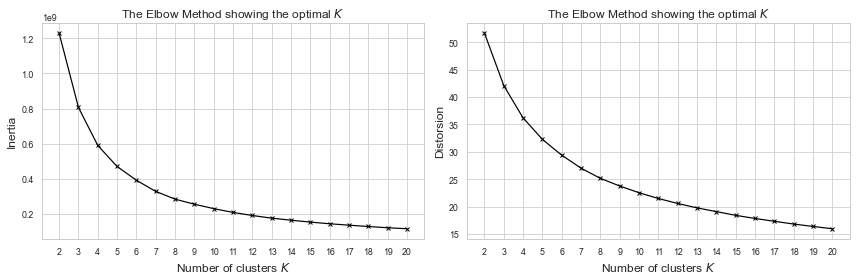

In [24]:

for prefixfull in [
    # "", 
                   "_built_environment"]:
    df_ori_within = generate_cluster(prefixfull)

# Reload the saved data

In [12]:
# summarize the cluster type
def summarize_cluster(df_ori_within, n, prefix):
    # variable_order = variables_sel_order[prefix]
    # use the reversed order
    variable_order = variables_sel_order[prefix + "_r"]
    df_summary = df_ori_within[variable_order+[f"cluster_{n}"]]\
        .groupby(f"cluster_{n}").mean().stack().reset_index()\
        .rename(columns = {"level_1":"category", 0:"std_value"})

    df_summary_update = []
    for v in df_summary["category"].unique():
        temp = df_summary[df_summary["category"]==v].reset_index(drop = True)
        temp["norm_value"] = (temp["std_value"] - temp["std_value"].min())/(temp["std_value"].max() - temp["std_value"].min())
        df_summary_update.append(temp)

    df_summary_update = pd.concat(df_summary_update).reset_index()

    df_heat = df_summary_update.pivot(
        columns= "category", values = "norm_value", index = f"cluster_{n}"
    )[variable_order].sort_values(variable_order[:5], ascending = False)
    return df_heat

In [13]:
# use heatmap to visualize the cluster
# n = 8
def plot_summary(df_ori_within, n, prefixfull):
    if prefixfull=="":
        figsize = (14, 4.5)
    else:
        figsize = (11, 4.5)
    fig, ax = plt.subplots(figsize = figsize)
    # use a gradient color
    # cluster_order = [3,2,5,6,0,4,1,7]
    df_heat = summarize_cluster(df_ori_within, n, prefixfull)
    cmap = sns.color_palette("blend:#88572C,#ddb27c,#b5f2f5,#12939a", as_cmap=True)
    sns.heatmap(df_heat.sort_values(['skyscraper','building']), 
                cmap = cmap, annot = True, fmt=".2f", 
                ax = ax)
    # show axis annotation larger
    ax.tick_params(axis='both', which='major', labelsize=12)
    # show ticks to the left
    ax.yaxis.tick_left()
    plt.yticks(rotation=0)
    # show ticks to the bottom
    ax.xaxis.tick_top()
    # rotate the x axis
    plt.xticks(rotation=45)
    plt.tight_layout()
    # save figure to svg
    plt.savefig(
        os.path.join(GRAPHIC_PATH, f"cluster_svf_attributes_{n}{prefixfull}.svg"),
        dpi = 200,
                )

In [6]:
# use the husl color to map to each cluster
import seaborn as sns
def get_color_palette(n):
    color_palette = sns.color_palette("husl", n)
    color_dict = dict(zip(range(n), color_palette))
    return color_palette, color_dict
# print the color palette

# color_palette, color_dict = get_color_palette(7)
# color_palette

In [11]:
# color_name_dict = dict(zip([cluster_name[i] for i in range(n)], color_palette))
# color_name_dict

In [12]:
# visualize one city
# get the geometry
import seaborn as sns
from shapely.geometry import Polygon
import geopandas as gpd
def get_color_palette(n):
    color_palette = sns.color_palette("husl", n)
    color_dict = dict(zip(range(n), color_palette))
    return color_palette, color_dict

def cell_to_shapely(cell):
    coords = h3.h3_to_geo_boundary(cell)
    flipped = tuple(coord[::-1] for coord in coords)
    return Polygon(flipped)

# loop through all cities and save the graphic and data
def get_result_within(df, city, n, plot = False,prefix = ""):
    color_palette, color_dict = get_color_palette(n)
    cityabbr = city.lower().replace(" ", "")
    sample = df[df["city_lower"]==cityabbr].reset_index(drop = True)
    h3_geoms = sample['hex_id'].apply(lambda x: cell_to_shapely(x))
    df_sel_gdf = gpd.GeoDataFrame(sample[['hex_id',f"cluster_{n}"]], geometry = h3_geoms)
    df_sel_gdf.crs = "EPSG:4326"
    df_sel_gdf[f"cluster_{n}"] = df_sel_gdf[f"cluster_{n}"].astype(str)
    # select the geometry within the boundary
    if "," in cityabbr:
        city_short = cityabbr.split(",")[0]
    else:
        city_short = cityabbr
    bound = gpd.read_file(os.path.join(BOUND_FOLDER, f"{city_short}.geojson"))
    assert bound.crs == df_sel_gdf.crs
    df_sel_gdf_within = gpd.sjoin(df_sel_gdf, bound[['geometry']])
    exportfolder = os.path.join(GRAPHIC_PATH, prefix+"cluster="+str(n))
    data_export_folder = os.path.join(DATA_EXPORT, prefix+"cluster="+str(n))
    if not os.path.exists(data_export_folder):
        os.makedirs(data_export_folder)
    if not os.path.exists(exportfolder):
        os.makedirs(exportfolder)
    # use the color palette to map the cluster consistently
    if plot:
        fig, ax = plt.subplots(figsize = (8,8))
        for c in range(n):
            to_plot = df_sel_gdf_within[df_sel_gdf_within[f"cluster_{n}"]==str(c)]
            if to_plot.shape[0]>0:
                to_plot.plot(ax = ax, 
                                    color = color_dict[c], 
                                    linewidth = 0.2,
                                    label = f"cluster_{c}",
                                    
                                    legend = True)
            else:
                continue

        plt.title(city)
        # hide the axis
        plt.axis('off')
        # add the legend
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
        plt.savefig(os.path.join(exportfolder, f"{city}_cluster={n}-tsn-res=9.png"), 
                dpi=200, bbox_inches = 'tight')
        plt.close()
    df_sel_gdf.to_file(os.path.join(data_export_folder,f"{city}_cluster={n}-tsn-res=9.geojson"), driver = "GeoJSON")
    return df_sel_gdf_within

def get_export_all(df_ori_within, n, prefix = ""):
    fullcity = df_ori_within["city_lower"].unique().tolist()
    allgdf = []
    for city in tqdm(fullcity):
        # print(city)
        df_sel_gdf = get_result_within(df_ori_within, city, n, True, prefix = prefix)
        df_sel_gdf['city_lower'] = city.split(",")[0]
        allgdf.append(df_sel_gdf)
    allgdf = pd.concat(allgdf)\
        .reset_index(drop = True)
    allgdf.drop(["geometry",'index_right'], axis = 1).to_csv(
        os.path.join(DATA_EXPORT, f"allcity{prefix}_cluster={n}.csv"), index = False
    )
    return allgdf


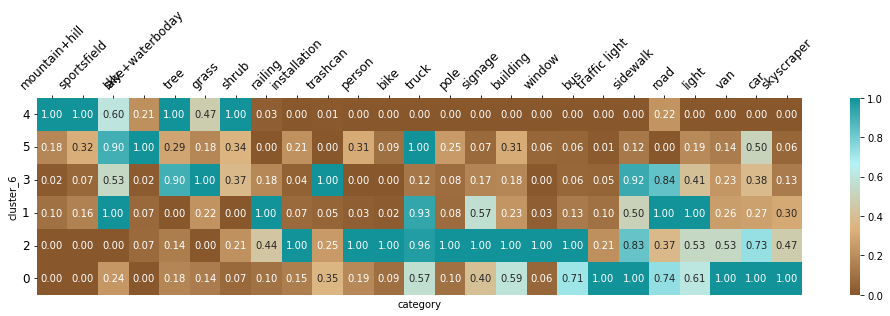

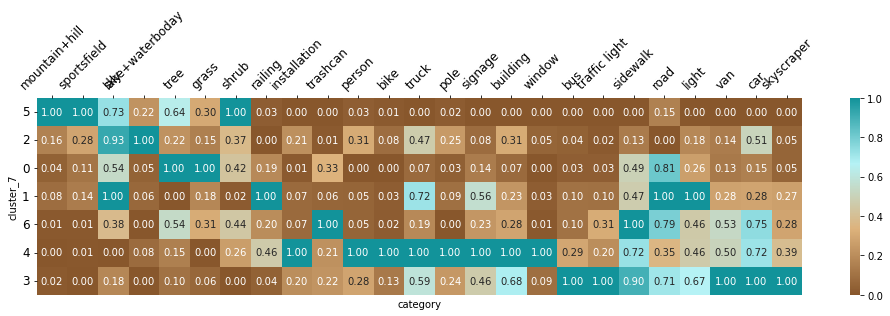

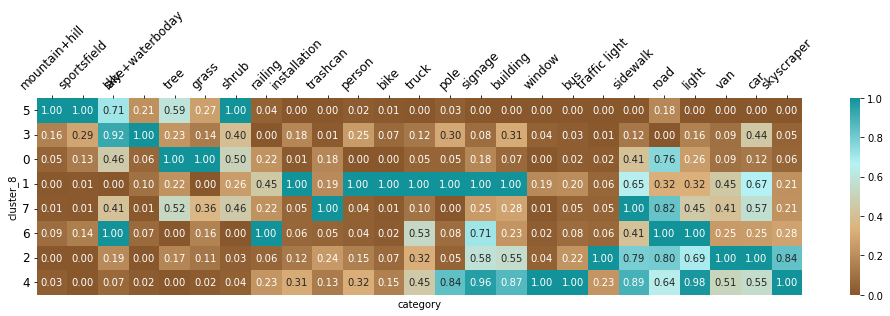

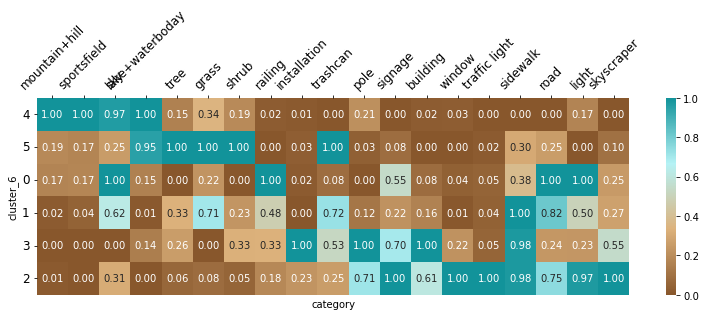

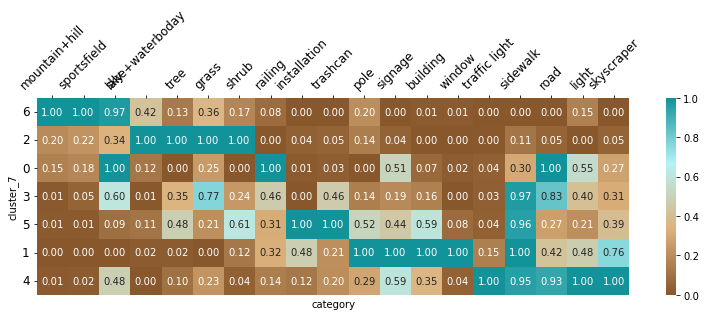

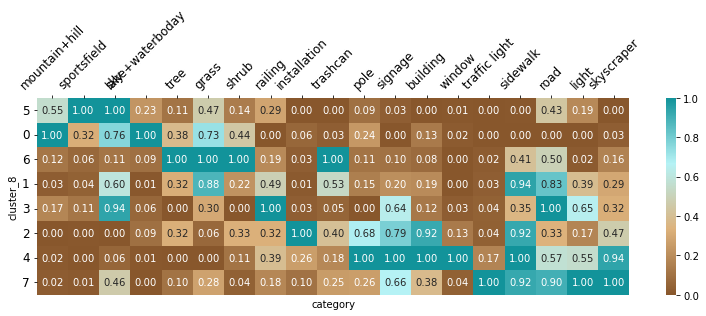

In [15]:

for prefixfull in [
    "", 
                   "_built_environment"]:
    df_ori_within = pd.read_csv(os.path.join(DATA_FOLDER, 
                              f"c_seg_cat={N_CAT}_res={res}_withincity{prefixfull}_tsne_cluster_range.csv"))
    for n in [6, 7,8]:
        plot_summary(df_ori_within, n, prefixfull)
        # allgdf = get_export_all(df_ori_within, n, prefix = prefixfull)

In [ ]:
city = "newyork"
temp = get_result_within(df_ori_within, city, 8, True, prefix = PREFIXFULL)

In [ ]:
city = "philadelphia"
temp = get_result_within(df_ori_within, city, 8, True, prefix = PREFIXFULL)


In [ ]:
temp = get_result_within(df_ori_within, "bangkok", 8, True, prefix = PREFIXFULL)

In [ ]:
temp = get_result_within(df_ori_within, "hongkong", 8, True, prefix = PREFIXFULL)

In [ ]:
city = "miami"
temp = get_result_within(df_ori_within, city, 7, True, prefix = PREFIXFULL)

In [ ]:
city = "singapore"
temp = get_result_within(df_ori_within, city, 7, True, prefix = PREFIXFULL)

In [ ]:
temp = get_result_within(df_ori_within, "tokyo", 8, True, prefix = PREFIXFULL)

In [ ]:
city = "london"
temp = get_result_within(df_ori_within, city, 7, True, prefix)

In [ ]:
city = "nairobi"
temp = get_result_within(df_ori_within, city, 7, True, prefix = PREFIXFULL)

In [ ]:
allgdf.shape

In [ ]:
# allgdf.to_file(os.path.join(DATA_FOLDER, f"all_city_res=9_cluster={N}.geojson"), driver = "GeoJSON")
# allgdf.drop('geometry', axis = 1).to_parquet(os.path.join(DATA_FOLDER, f"all_city_within_boundary_res=9_cluster={n}.parquet"))
# allgdf.drop('geometry', axis = 1).to_csv(os.path.join(DATA_FOLDER, f"all_city_within_boundary_res=9_cluster={n}.csv"), index = False)

## 2. Summarize the results across cities

In [ ]:

def get_summary(n, prefix = ""):
    df_summary= pd.read_csv(os.path.join(DATA_EXPORT, f"allcity_{prefix}cluster={n}.csv")).groupby(["city_lower",f"cluster_{n}"])\
        .size().reset_index().rename(columns = {0:"count"}).pivot(
        columns = f"cluster_{n}", values = "count", index = "city_lower").fillna(0)
    df_summary['total'] = df_summary.sum(axis = 1)
    df_summary_prop = df_summary.copy()
    for i in range(n):
        df_summary_prop[i] = df_summary_prop[i]/df_summary_prop['total']
    df_summary_prop.to_csv(os.path.join(DATA_EXPORT, f"allcity_{prefix}cluster={n}_city-level_summary.csv"))
    return df_summary_prop
# df_summary_prop = get_summary(n)
df_summary_prop = get_summary(n, prefix = "built_env")
df_summary_prop.sort_values(n-1, ascending = False).head(40)

In [ ]:
test = pd.read_csv("/Users/yuan/Dropbox (Personal)/Personal Work/_Projects2023/01_city-never-was/_data/_curated/c_seg_hex/c_seg_cat=31_res=9_withincity_built_environment_tsne_cluster_range.csv")